In [ ]:
import import_ipynb
from KEM_General import Super_General_Model

In [1]:
import numpy as np
from statistics import mean
from itertools import zip_longest
import operator
import statistics
import statistics as stat
import statistics as stats
import itertools
from copy import deepcopy
import copy
from scipy.stats  import multivariate_normal
import matplotlib 
# matplotlib.use('TkAgg')
%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
from IPython.core.debugger import set_trace
import random
import time
import math
import seaborn as sns; sns.set()
import pylab
from random import randrange
import sys 
import scipy
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy.ma as ma
import multiprocessing as mp
from IPython.core.debugger import Tracer

import warnings
warnings.filterwarnings("ignore")

In [ ]:
class spatial_kem(Super_General_Model):
    
    class Agent:
        def __init__(self, wealth = 0., lambda_ = 0.):
            self.wealth = wealth
            self.lambda_ = lambda_
            
    def populate(self, grid_size = (500, 500), distr ="Rand", n=2):
        #make sure to transform grid_size --> N
        #add mu
        # add super.__init__check Jake for that
        
        '''
        Left out in general model inputs? 
        
        
        Inputs:
            - Grid size: size of the grid.
            - Distribution: str.Showing type of initial distribution of the grid
                            Seg: Segregated
                            SM: Semi-mixed (greater granulity)
                            Mix: Completely mixed
                            Rand: Random grid
 
            - In case of SM distribution, n is an int value that represents
                the size of the neighborhoods. Default: 2.
                    
            
        '''
        self.time = 0 
        
        # Random grid case
        if distr == "Rand":
            wealths = np.ones(grid_size)
            for i in range(grid_size[0]):
                for j in range(grid_size[1]):
                    wealths[i][j] = np.random.uniform(0, 100) 

        ############ TODO change this later #############
        # Segregated grid case
        elif distr == "Seg":
            wealths = np.ones(grid_size)*5
            wealths[:, :int(grid_size[1]/2)]= 1
        
        
        # Semi-mixed grid case, using n to consider the granularity
        elif distr == "SM":
            wealths = np.ones(grid_size)*5
            
            for i in range(n, 2*n):
                for j in range(n):
                    wealths[j::2*n, i::2*n] =1

            for i in range(n):
                for j in range(n, 2*n):
                    wealths[j::2*n, i::2*n] =1
                    
            
        #well mixed grid
        elif distr == "Mix" :
            wealths = np.ones(grid_size)*5
            for i in range(grid_size[0]):
                for j in range(grid_size[1]):
                    if (i+j)%2:
                        wealths[i][j] = 1
                        
                        
        lamb = np.ones(grid_size)
        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                lamb[i][j] = np.random.power(0.3) 
                
        
        self.population = np.ones(grid_size)
        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                self.population[i][j] = self.Agent(income = wealths[i][j], lamba_ = lamb[i][j]) 

                
    def choose_agents(self):
        '''
        Takes one actor randomly from the whole grid, 
        and a random neighbor actor.

        '''
        random_cell =random.sample(range(self.grid_size[0]), 2)
        x = random_cell[0]
        y = random_cell[1]

        #having cut-off boundary conditions
        if x == 0:
            a =[0, 1]

        elif x == (self.grid_size[0]-1):
            a = [-1, 0]

        elif x !=0 and x !=(self.grid_size[0]-1):
            a=[-1, 0, 1]

        if y == 0:
            b = [0, 1]

        elif y == (self.grid_size[1]-1):
            b = [-1, 0]

        elif y !=0 and y != (self.grid_size[1]-1):
            b= [-1, 0, 1]

        combinations = itertools.product(a, b)

        neighbors = []
        for xi, yi in combinations:
            x_coordinate = (x + xi) % len(self.wealths[0])
            y_coordinate = (y + yi) % len(self.wealths[1])

            neighbors.append((x_coordinate, y_coordinate))

        neighbors.remove((x, y))
        choice = random.choice(neighbors)
        
        return self.population[x][y], self.population[choice[0]][choice[1]]
    
    def get_income_dist(self):
        """
        returns the income distribution as a list of incomes
        """
#       return the flatten list of population?
        
        return [a.income for a in self.population.flatten()]
        
    
    def interact(self, agents):
        eps = np.random.uniform()
        A,B = agents

        A.wealth, B.wealth = A.lamba_*A.wealth + eps*((1-A.lamba_) * A.wealth + (1 - B.lamba_)*B.wealth), B.lamba_*B.wealth + (1-eps)*((1 - A.lamba_) * A.wealth + (1 - B.lamba_)*B.wealth)
        return self.get_income_dist()
    
 
        

## KEM model implemented in Grid

This model takes a random cell from a grid, and a random neighbor from its Moore neighborhood (excluding itself) and make them interact through a specific transaction function. It outputs the deciles dynamics through time, its statistics, plot and distribution through time.

In [ ]:
class grid_kem(object):
    def __init__(self, grid_size = (50, 50), distr ="Rand", n=2):
        '''
        Inputs:
            - Grid size: size of the grid.
            - Distribution: str.Showing type of initial distribution of the grid
                            Seg: Segregated
                            SM: Semi-mixed (greater granulity)
                            Mix: Completely mixed
                            Rand: Random grid
 
            - In case of SM distribution, n is an int value that represents
                the size of the neighborhoods. Default: 2.
                    
            
        '''
        #initiating
        self.grid_size = grid_size
        self.distr = distr
        self.n = n

        #populate 
        self.populate(grid_size, distr, n)
        
        #counting steps
        self.step = 0
    
    
    def populate(self, grid_size, distr, n):
        '''
        Populate the grid.
        Input: 
            - Grid Size (grid_size)
            - Distribution (distr)
            - Granularity size (n)
        
        We populate the grid depending on the type of geometry distribution selected.
        (Well mixed city (chessboard-like), Semi-mixed(chessboard-like but with greater granularity (n)), 
        Segregated (completely segregated grid))
        In this case we just have two possible income values 5 or 1, this allows us to simplify possible 
        outcomes of the model.
        
        Output:
            Income grid with selected attributes.
            We may add the "savings distributions right here.
        
        '''
        # Random grid case
        if self.distr == "Rand":
            self.income = np.ones(self.grid_size)
            for i in range(self.grid_size[0]):
                for j in range(self.grid_size[1]):
                    self.income[i][j] = np.random.uniform(0, 100) 


        # Segregated grid case
        elif self.distr == "Seg":
            self.income = np.ones(self.grid_size)*5
            self.income[:, :int(self.grid_size[1]/2)]= 1
        
        
        # Semi-mixed grid case, using n to consider the granularity
        elif self.distr == "SM":
            self.income = np.ones(self.grid_size)*5
            
            for i in range(self.n, 2*self.n):
                for j in range(self.n):
                    self.income[j::2*self.n, i::2*self.n] =1

            for i in range(self.n):
                for j in range(self.n, 2*self.n):
                    self.income[j::2*n, i::2*self.n] =1
                    
            
        #well mixed grid
        elif self.distr == "Mix" :
            self.income = np.ones(self.grid_size)*5
            for i in range(self.grid_size[0]):
                for j in range(self.grid_size[1]):
                    if (i+j)%2:
                        self.income[i][j] = 1
                        
                        
        self.lamb = np.ones(self.grid_size)
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                self.lamb[i][j] = np.random.power(0.3) 
                
        

        
    def gini(self, p):
        '''
        Gini coefficient (equation from wikipedia)
        
        '''
    
        y = sorted(p)
        n = len(p)

        numer = 2 * sum((i+1) * y[i] for i in range(n))
        denom = n * sum(y)

        return (numer / denom) - (n + 1) / n
    
    
    def percent(self, pct, items):
        '''
        The item that is pct percent through the sorted list of items.

        '''
        return items[min(len(items)-1, len(items) * pct // 100)]

        
    def display(self):
        '''
        Plot the state of the model.
        
        '''
        plt.figure()
        plt.imshow(self.income)
        plt.colorbar()
        plt.title('Step: ' + str(self.step))
        
        
    def hist(self, p, label='Dist', **kwargs):
        
        label = label + ': G=' + str(round(self.gini(p), 2))

        h = plt.hist(list(p), alpha = 0.4, bins = 30, label= label, **kwargs)

        plt.xlabel('Income')
        plt.ylabel('Count')
        plt.grid(True)

        plt.legend()
        
        
    def interaction(self, income): 
        '''
        Takes one actor randomly from the whole grid, 
        and a random neighbor actor.

        '''
        random_cell =random.sample(range(len(self.income)), 2)
        x = random_cell[0]
        y = random_cell[1]

        #having cut-off boundary conditions
        if x == 0:
            a =[0, 1]

        elif x == (self.grid_size[0]-1):
            a = [-1, 0]

        elif x !=0 and x !=(self.grid_size[0]-1):
            a=[-1, 0, 1]

        if y == 0:
            b = [0, 1]

        elif y == (self.grid_size[1]-1):
            b = [-1, 0]

        elif y !=0 and y != (self.grid_size[1]-1):
            b= [-1, 0, 1]

        combinations = itertools.product(a, b)

        neighbors = []
        for xi, yi in combinations:
            x_coordinate = (x + xi) % len(self.income[0])
            y_coordinate = (y + yi) % len(self.income[1])

            neighbors.append((x_coordinate, y_coordinate))

        neighbors.remove((x, y))
        choice = random.choice(neighbors)
        return (x, y), (choice[0], choice[1]) 
        
    def transaction(self, A, B):
        '''
        Type of Transaction, this is subject to change.
        
        '''
        eps = np.random.uniform()

    
        return self.lamb[A]*self.income[A] + eps*((1-self.lamb[A]) * self.income[A] + (1 - self.lamb[B])*self.income[B]), self.lamb[B]*self.income[B] + (1-eps)*((1 - self.lamb[A]) * self.income[A] + (1 - self.lamb[B])*self.income[B])
    
    
    def simulate(self, income, k=500, **kwargs):
        '''
        Simulate takes a certain initial population, and makes them interact.

        Inputs:
            population. list. Initial income distribution
            steps. int. Time steps to execute the simulation
            transaction. function. function that describes the dynamic of the transaction.
            interaction. function. function that describes the dynamic of the interaction.

        Outputs:
            population after steps number of steps. 

        '''
        #         self.income = deepcopy(self.income)
        
        
        steps = k*self.grid_size[0]**2
        
        self.results = []
        self.sorted_results=[]
        self.times = []

        self.results.append(self.income)
        self.times.append(0)
        
        pool = mp.Pool(mp.cpu_count())
        
        def task(income):
            '''
            Returns the updated grid after a certain iteration
            '''
            A, B = self.interaction(income)
            self.income[A], self.income[B] = self.transaction(A, B)
            return list(self.income.flatten())
        
        set_trace()
        re =[]
        for _ in range(1, steps+1):
            r = pool.apply(task, args=(self.income))
            re.append(r)
        pool.close()
        
        for t, pop in enumerate(r):
            if t % ((self.grid_size[0]**2)/10) == 0:
                self.times.append(t)
                self.results.append(pop)
                self.sorted_results.append(sorted(pop))
        
        return self.results, self.sorted_results, self.times
    
#     def run(self, income, k=500, **kwargs):
#         '''
#         Run the simulation for k* grid_size[0] steps, 
#         return updated grid
        
#         '''
        
#         results = []
#         sorted_results = []
#         times = []
        
#         for (t, pop) in enumerate(self.simulate(self.income, k*self.grid_size[0]**2, **kwargs)):
#             if t % ((self.grid_size[0]**2)/10) == 0:
                
#                 results.append(copy.copy(list(pop.flatten())))
#                 sorted_results.append(sorted(list(pop.flatten())))
#                 times.append(copy.copy(t))
                
#         return results, sorted_results, times
    
    def show(self, income, k=500, percentiles=(1, 10, 50, 90, 99), **kwargs):
        '''
        Print stats, plot and histogram
        
        '''
        N = self.grid_size[0]
        
        start = list(self.income.flatten())
        
        results, sorted_results, times = self.simulate(self.income, k, **kwargs)
        
        # Statistics
        print('   t    Gini stdev' + (' {:3d}%' * len(percentiles)).format(*percentiles))
    
        fmt = '{:7,d} {:.2f} {:5.1f}' + ' {:4.0f}' * len(percentiles)
                
        for (t, pop) in zip(times, sorted_results):
            if t % (N/10) == 0:
                data = [self.percent(pct, pop) for pct in percentiles]
                print(fmt.format(t, self.gini(pop), statistics.stdev(pop), *data))
        
        # Plot

        plt.xlabel('Time')
        plt.ylabel('Wealth')
        plt.grid(True)

        for pct in percentiles:
            line = [self.percent(pct, pop) for pop in sorted_results]
            plt.plot(times, line)

        plt.show()
            
            
        # Histogram
        pop = results[-1]
        R = (min(pop+start), max(pop+start))
        self.hist(start, 'Initial', range=R)
        self.hist(pop, 'Final', range=R)
        plt.show()
        plt.close() 
        

### Simulation output

Running a (500, 500) random uniformly distributed grid size, in 500\* grid_size time steps.

In [ ]:
sim = grid_kem()
sim.show(sim.income)

### Comparing population sizes

In this section, we are running a random uniformly distributed grid, with different grid sizes.

In [ ]:
'''
Run the simulation with different grid sizes.
Record wealth outputs.

'''
grids =[i for i in range(5, 1025, 25)]

hists = []
percs = []

for i in grids:
    sim = grid_kem(grid_size= (i, i))
    sub_hists = []
    sub_percs = []
    for _ in range(31):
        results, sorted_results, times = sim.run(sim.income)
        sub_hists.append(results[-1])
        sub_percs.append(sorted_results[-1])
        
    avg_hists = [*map(mean, zip(*sub_hists))]
    hists.append(avg_hists)
    
    avg_percs = [*map(mean, zip(*sub_percs))]
    hists.append(avg_percs)


In [ ]:
'''
Plotting/Animated the change of final distribution for different city sizes.

'''
def animate(i):
    
    plt.cla()
    
    lbl = "Population = "+ str(grids[i])
    sns.distplot(hists[i], kde= True, bins = 30, label=lbl)

    plt.xlabel('Wealth')
    plt.ylabel('Count')
    
    plt.grid(True)
    plt.legend()

anim = FuncAnimation(plt.figure(), animate, frames=len(hists))
HTML(anim.to_jshtml())

#### Comparison of Moments

Analyzing statistical model through grid size.

In [ ]:
means = [stats.mean(i) for i in hists]

fig = plt.figure()
fig.plot(grids, means)
fig.set_yscale('log')
plt.xlabel('Grid Size')
plt.ylabel('Wealth Mean')

plt.show()

In [ ]:
stds = [stats.stdev(i) for i in hists]


fig = plt.figure()
fig.plot(grids, stds)
fig.set_yscale('log')
plt.xlabel('Grid Size')
plt.ylabel('Wealth stdev')
plt.show()

In [ ]:
medians = [stats.median(i) for i in hists]

fig = plt.figure()
fig.plot(grids, medians)
fig.set_yscale('log')
plt.xlabel('Grid Size')
plt.ylabel('Wealth median')
plt.show()

In [ ]:
'''
Run the simulation with different grid sizes.
Record income outputs.

'''
grids =[i for i in range(5, 1025, 25)]

hists = []
percs = []

for i in grids:
    sim = grid_kem(grid_size= (i, i))
    sub_hists = []
    sub_percs = []
    for _ in range(31):
        results, sorted_results, times = sim.run(sim.income)
        sub_hists.append(results[-1])
        sub_percs.append(sorted_results[-1])
        
    avg_hists = [np.ma.average(ma.masked_values(temp_list, None)) for temp_list in izip_longest(*sub_hists)]
    hists.append(avg.hists)
    
    avg_percs = [np.ma.average(ma.masked_values(temp_list, None)) for temp_list in izip_longest(*sub_percs)]
    hists.append(avg.[percs])

    
    

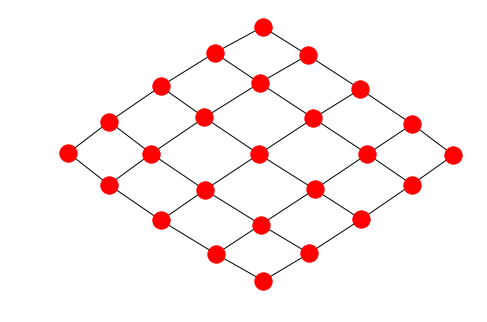

In [9]:
import networkx as nx
%matplotlib inline
from matplotlib import pyplot as plt

G= nx.grid_2d_graph(5, 5, periodic=False, create_using=None)

# write edgelist to grid.edgelist
nx.write_edgelist(G, path="grid.edgelist", delimiter=":")
# read edgelist from grid.edgelist
H = nx.read_edgelist(path="grid.edgelist", delimiter=":")

nx.draw(H)
plt.show()